# Weighted PCA

[Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) is an extremely useful tool in a variety of contexts, but the standard algorithm cannot handle datasets with noisy or missing entries.
There have been several extensions proposed to PCA which can handle noisy and missing data.
This notebook gives a short motivation and demonstration of two such algorithms implemented in the `wpca` package (http://github.com/jakevdp/wpca/), a lightweight pure-Python package which depends only on numpy, scipy, and scikit-learn.

``wpca`` can be installed using

```
$ pip install wpca
```

The package implements three scikit-learn-compatible estimators for PCA and weighted PCA:

- ``wpca.WPCA``, based on the algorithm presented in
  [Delchambre (2014)](http://arxiv.org/abs/1412.4533),
  uses a direct decomposition of a weighted covariance matrix to
  compute principal vectors, and then a weighted least squares optimization
  to compute principal components.

- ``wpca.EMPCA``, based on the algorithm presented in
  [Bailey (2012)](http://arxiv.org/abs/1208.4122),
  uses an iterative expectation-maximization approach to solve
  simultaneously for the principal vectors and principal components of
  weighted data.

- ``wpca.PCA`` is a standard non-weighted PCA implemented using the singular
  value decomposition. It is included mainly for the sake of testing and comparison.
  
Though ``WPCA`` and ``EMPCA`` are similar, they emphasize different aspects of the PCA problem and thus produce slightly different results – for more information, see the discussion in Delchambre (2014).

Let's take a look at these methods in action.

In [110]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import seaborn; seaborn.set() # set plot style

from wpca import PCA, WPCA, EMPCA

## Simulated Data

For simplicity, we will create a straightforward dataset of 1000 sinusoids sampled at a regular interval, with random amplitudes and phases:

$$
x = A \sin[2\pi (t - \phi)]
$$

The benefit of this choice is that we *know* the data lie on a two-dimensional manifold, defined by the eigenvectors

$$
e_1 = \sin(t)\\
e_2 = \cos(t)
$$

Here we will create 1000 such sinusoids, each sampled at 50 values of $t$, resulting in a 50-dimensional dataset:

In [111]:
n_samples = 1000
n_features = 50

rand = np.random.RandomState(42)
amp = rand.randn(n_samples, 1)
phase = rand.rand(n_samples, 1)
t = np.linspace(0, 1, n_features)
Xtrue = amp * np.sin(2 * np.pi * (t - phase))

Xtrue.shape # n_samples x n_features

(1000, 50)

In [112]:
apd_traces =[]

apd_traces_file = open("apdtraces_run166.dat")
for i in range(10000):
    line_data = [float(i) for i in apd_traces_file.readline().split(" ")]
    line_data-=np.mean(line_data[:25])
    apd_traces.append(line_data)

apd_traces = np.array(apd_traces)
apd_traces_file.close()
Xtrue = apd_traces

Here are the first ten of these data points:

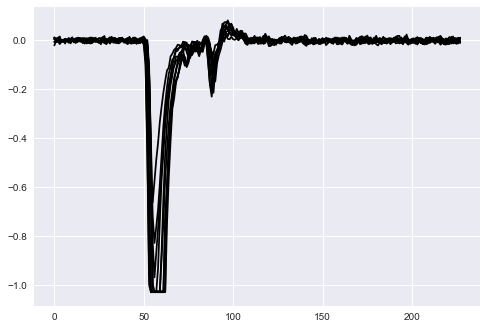

In [113]:
plt.plot(Xtrue[:10].T, c='black');

To make this more interesting, let's add some normally-distributed noise to the data:

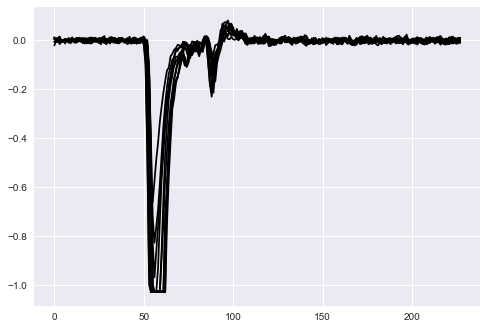

In [114]:
err = 0.0002 * np.ones_like(Xtrue)
X = rand.normal(Xtrue, err)
plt.plot(X[:10].T, c='black');

## Reconstructing the Data with PCA

PCA fundamentally seeks vectors within the dataset along with the variance is mazimized.
Under the assumption that the overall variance due to the signal is larger than the overall variance due to the noise, the first few PCA components will contain an approximation to the de-noised signal. In this way, PCA can be used to "reconstruct" input data from a noisy sampling.

This is easier to appreciate if we look at it graphically; to this end we'll create a quick convenience routine that we'll use below:

In [115]:
def plot_results(ThisPCA, X, weights=None, Xtrue=None, ncomp=2):
    # Compute the standard/weighted PCA
    if weights is None:
        kwds = {}
    else:
        kwds = {'weights': weights}
    
    # Compute the PCA vectors & variance
    pca = ThisPCA(n_components=10).fit(X, **kwds)
    
    # Reconstruct the data using the PCA model
    Y = ThisPCA(n_components=ncomp).fit_reconstruct(X, **kwds)
        
    # Create the plots
    fig, ax = plt.subplots(2, 2, figsize=(16, 6))
    if Xtrue is not None:
        ax[0, 0].plot(Xtrue[:10].T, c='gray', lw=1)
        ax[1, 1].plot(Xtrue[:10].T, c='gray', lw=1)
    ax[0, 0].plot(X[:10].T, c='black', lw=1)
    ax[1, 1].plot(Y[:10].T, c='black', lw=1)
    
    ax[0, 1].plot(pca.components_[:ncomp].T, c='black')
    
    ax[1, 0].plot(np.arange(1, 11), pca.explained_variance_ratio_)
    ax[1, 0].set_xlim(1, 10)
    ax[1, 0].set_ylim(0, None)
    
    ax[0, 0].xaxis.set_major_formatter(plt.NullFormatter())
    ax[0, 1].xaxis.set_major_formatter(plt.NullFormatter())
    
    ax[0, 0].set_title('Input Data')
    ax[0, 1].set_title('First {0} Principal Vectors'.format(ncomp))
    ax[1, 1].set_title('Reconstructed Data ({0} components)'.format(ncomp))
    ax[1, 0].set_title('PCA variance ratio')
    ax[1, 0].set_xlabel('principal vector')
    ax[1, 0].set_ylabel('proportion of total variance')
    
    fig.suptitle(ThisPCA.__name__, fontsize=16)
    
    return Y

Now let's plot the reconstruction of the noisy data using standard PCA:

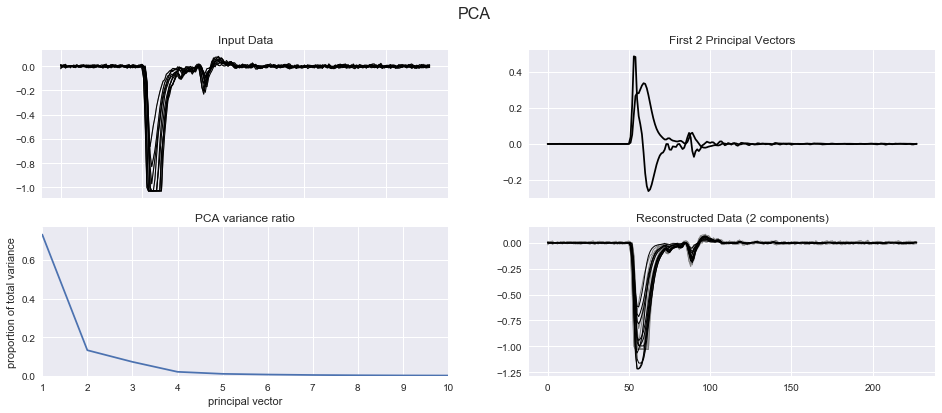

In [116]:
plot_results(PCA, X, Xtrue=Xtrue);

It is clear here that even in the presence of moderate noise, the PCA algorithm found two dominant principal vectors (lower left), and that these principal vectors are the two sinusoids that we expected them to be (upper right).
Further, using these two principal components we can denoise the data, reconstructing the input remarkably well (lower right – gray curves show the true data and black curves show the reconstruction).

## Heteroscedastic Noise

The above works well if your noise is homoscedastic – that is, the same for each measurement – but when you have heteroscedastic noise – noise levels which vary from measurement to measurement – the PCA model assumptions can fail.

For example, here we'll add large errors at random to 10% of the values in our dataset:

In [117]:
err = 0.000000001 * np.ones_like(X)
i = rand.randint(0, err.shape[0], 5000)
j = rand.randint(0, err.shape[1], 5000)
err[i, j] = 10.0
X = rand.normal(Xtrue, err/100000000000000.0)

Repeating the above exercise, we see that standard PCA does not perform quite as well:

array([[ 0.00050497, -0.00027931,  0.00045884, ..., -0.00018599,
         0.00188645,  0.0012435 ],
       [ 0.00054737, -0.00020643,  0.00049784, ...,  0.00022098,
         0.00151956,  0.00045725],
       [ 0.0006558 , -0.00034605,  0.00010522, ...,  0.00107805,
         0.00335048,  0.00187791],
       ..., 
       [ 0.0003602 , -0.00046155,  0.00042621, ..., -0.00153782,
         0.00257358,  0.00322703],
       [ 0.00055428, -0.00039124,  0.00020713, ...,  0.00017647,
         0.00313052,  0.00239937],
       [ 0.00039165, -0.00019558,  0.00077522, ..., -0.00111664,
         0.00050127,  0.0004133 ]])

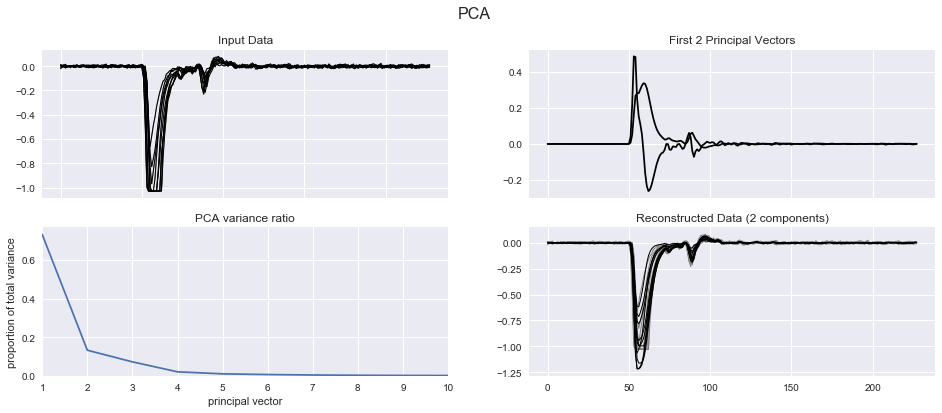

In [118]:
plot_results(PCA, X, Xtrue=Xtrue)

In particular, we no longer have two dominant components: in the presence of heteroscedastic noise, the PCA routine is unable to cleanly separate signal and noise, and we are left with not-so-useful eigenvectors which result in a very poor reconstruction of the data.

Recall that 90% of our data is precisely the same as before: it's only 10% of measured values that have the additional large errors.
We might *hope* that PCA would be able to take this into account, de-weighting the portions of the data that we know are poorly-constrained, but for the standard algorithm this is not the case.

### Weighted PCA

There have been a number of extensions to PCA proposed which can handle weights on each input value.
Here we will show two different approaches to solving the weighted PCA problem, the ``WPCA`` method of [Delchambre (2014)](http://arxiv.org/abs/1412.4533), and the ``EMPCA`` method of [Bailey (2012)](http://arxiv.org/abs/1208.4122).

In both cases, the weights are mathematically equivalent to the inverse of the Gaussian errors on each point, and for equal weights the result reduces to that of standard PCA.
Let's construct the weights and compute the result with each method:

In [123]:
#weights = 1. / err
weights = 1*(abs(X)<.90).astype(int)

In [124]:
#for method in [WPCA, EMPCA]:
#    plot_results(method, X, weights, Xtrue=Xtrue)

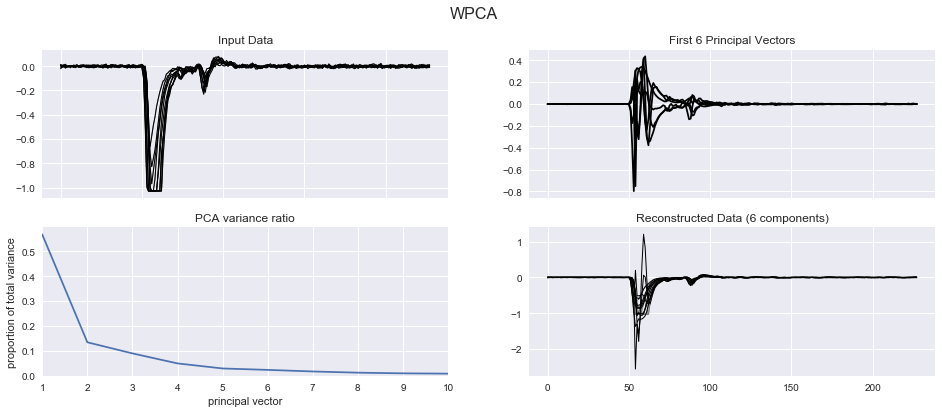

In [128]:
reconstructed = plot_results(WPCA, X, weights, Xtrue=Xtrue,ncomp=6)

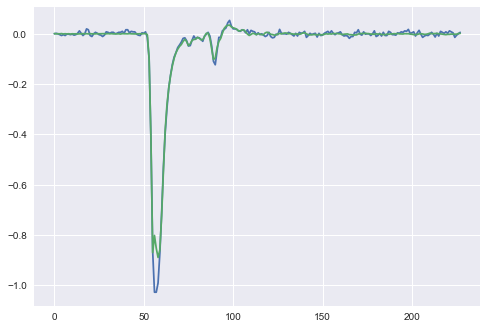

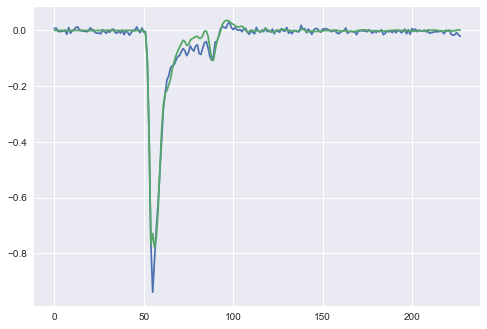

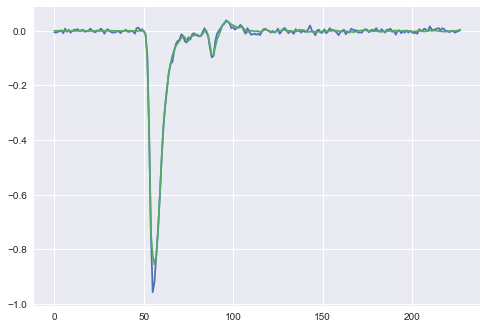

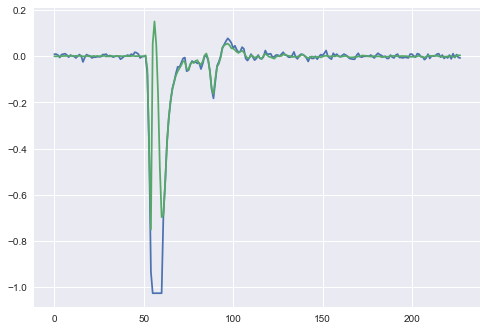

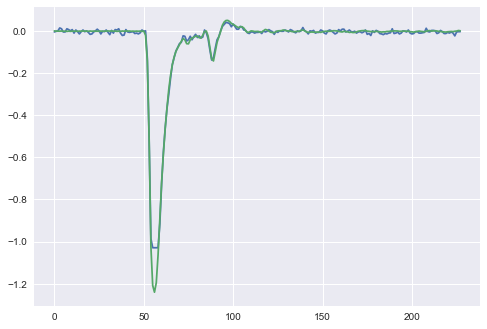

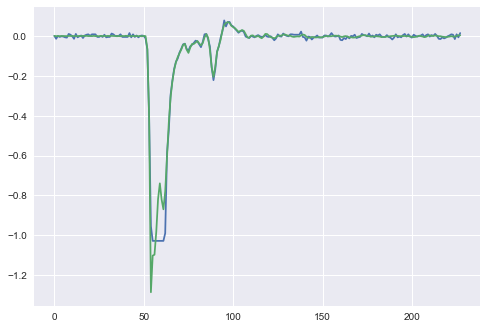

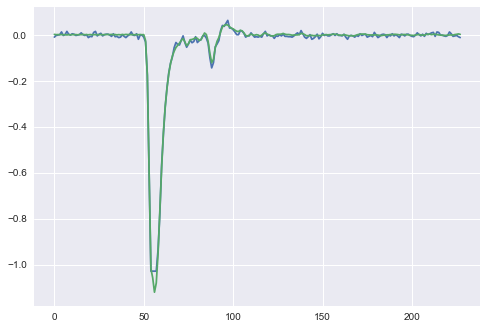

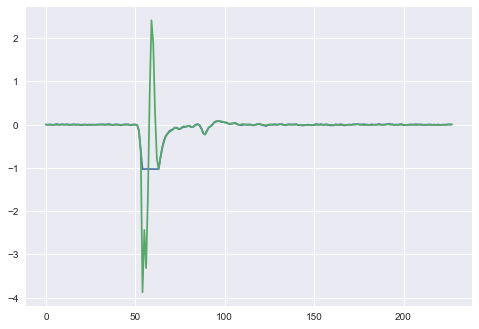

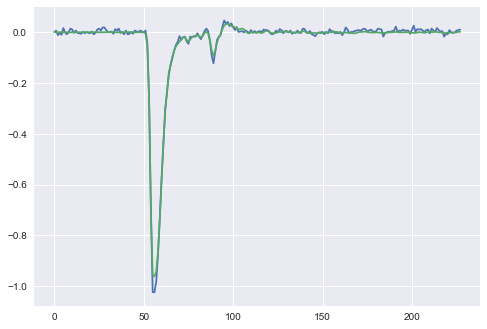

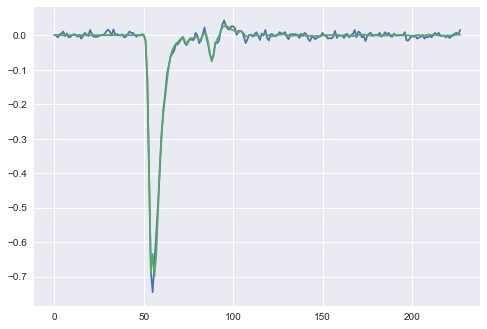

In [130]:
for i in (10000*np.random.rand(10)).astype(int):
    plt.plot(X[i])
    plt.plot(reconstructed[i])
    plt.show()

We see that even with this very noisy data the weighted PCA algorithms can cleanly separate the signal and the noise, and recover the two dominant eigenvectors we hope to find.

## Masked Data

At the extreme end of this is data which has missing values: missing values can be viewed as data with infinite variance, and thus weights are equal to zero.
Here let's convert our outliers to true missing values, and set the weight array to zero to reflect this:

In [11]:
X[i, j] = np.nan  # nan = Not A Number
weights[i, j] = 0

Plotting the results, we see that even in the case of missing data, the principal vectors and data reconstructions remain robust:

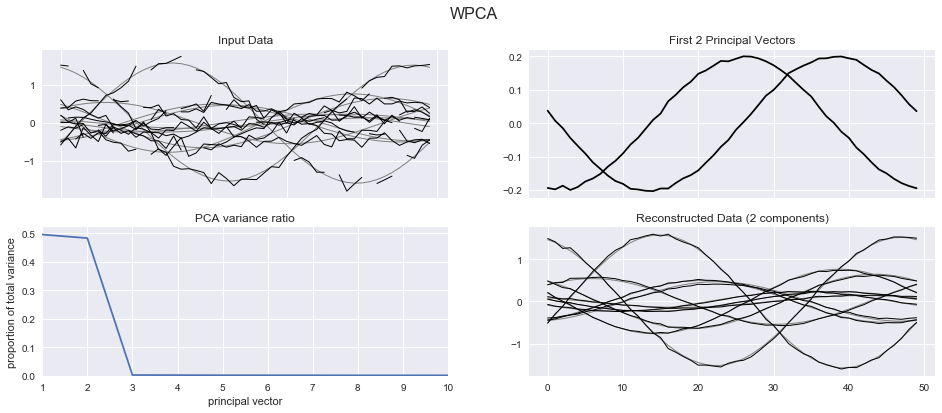

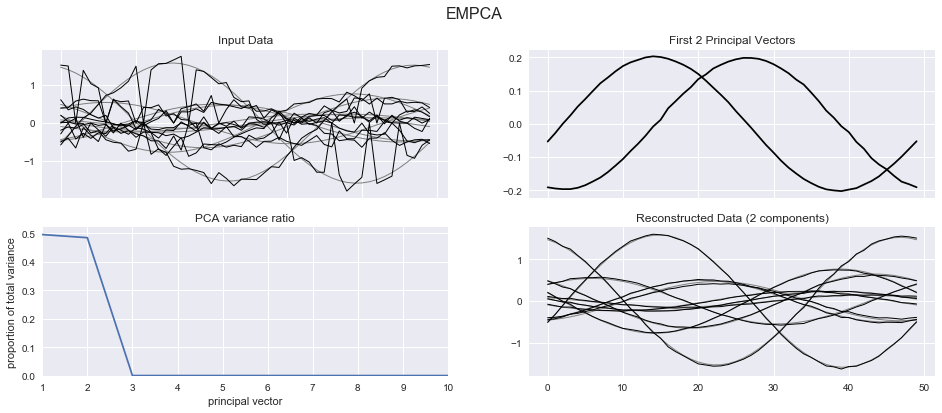

In [12]:
for method in [WPCA, EMPCA]:
    plot_results(method, X, weights, Xtrue=Xtrue)

If you would like to try these weighted PCA implementations for yourself, see http://github.com/jakevdp/wpca/.